

# Representation Similarity Analysis (RSA)

Here, we will illustrate the principal of RSA using the MNE-Python sample data set. For more information, see notebook E_2_RSAToolbox.ipynb.


In [1]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_examples/decoding/decoding_rsa_sgskip.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import sample

data_path = sample.data_path()

subjects_dir = data_path / "subjects"
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
tmin, tmax = -0.200, 0.500
event_id = {"Auditory/Left": 1, "Auditory/Right": 2, "Visual/Left": 3, "Visual/Right": 4}  # just use two
raw = mne.io.read_raw_fif(raw_fname)
raw.pick(picks=['eeg', 'meg', "stim", "eog"])

# Filter
raw.load_data().filter(0, 40)
events = mne.find_events(raw, "STI 014")

# Set up bad channels (modify to your needs)
raw.info["bads"] += ["MEG 2443"]  # bads + 2 more

# channel type(s) used for RSA
ch_type = ['grad']

# reject criteria according to channel type(s)
# reject = dict(mag=4000e-15, grad=4000e-13, eeg=150e-6, eog=250e-6)
reject = dict(grad=4000e-13, eog=250e-6)

# Create epochs
epochs_ori = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    baseline=(None, 0.0),
    preload=True,
    reject=reject,
    decim=3,  # decimate to reduce computation time (note low-pass filter above)
    verbose="error",
)

epochs = epochs_ori.copy().pick(picks=ch_type, exclude="bads")  # remove stim and EOG

Opening raw data file C:\Users\olaf\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 51 samples (0.340 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.3s


319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


Note: We do this for "single trials", but in this case we only have four stimulus categories.

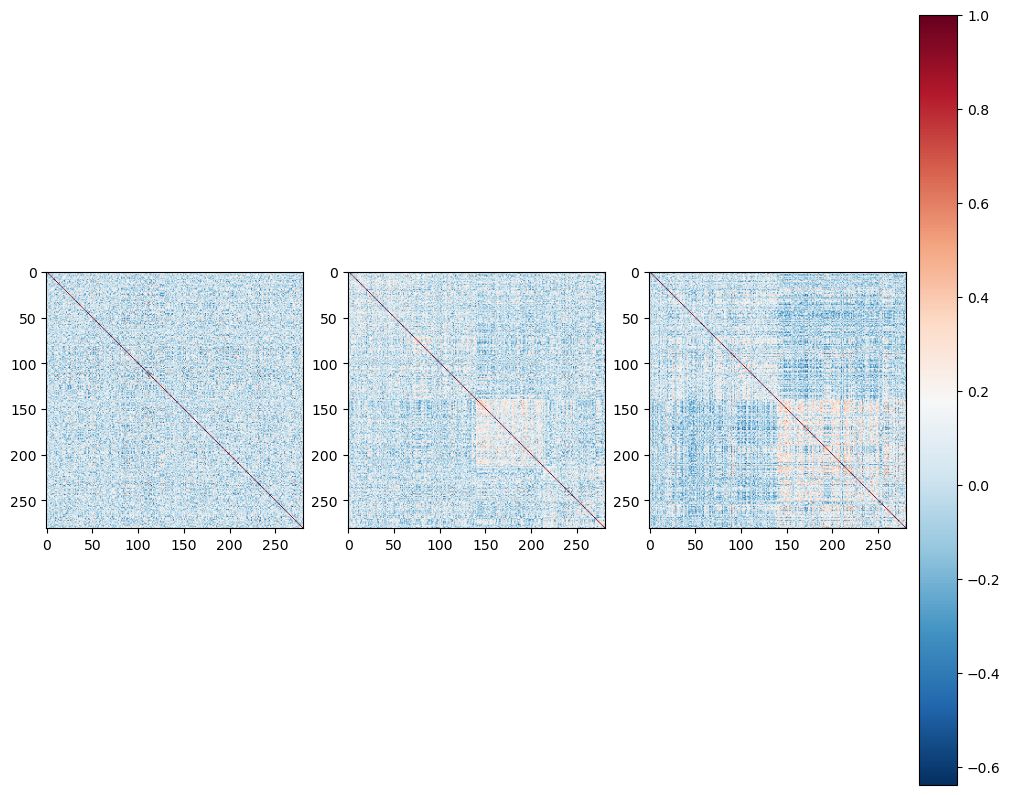

In [3]:
times = [0., 0.15, 0.2]

idx = epochs.time_as_index(times)

fig, axes = plt.subplots(1, len(times), figsize=(10, 10), layout="constrained")
for [times, i, ax] in zip(times, idx, axes):
    X = []
    for cond in event_id:
        X.append(epochs[cond].get_data()[:, :, i].squeeze())
    X = np.vstack(X)

    rdm = np.corrcoef(X)
    
    im = ax.imshow(rdm, cmap="RdBu_r")

plt.colorbar(im)


In [4]:
# create a "model matrix" for within category correlations
within = np.zeros(rdm.shape)
cnt = 0
for cond in event_id:
    n_cond = len(epochs[cond])
    within[cnt:cnt+n_cond, cnt:cnt+n_cond] = 1
    cnt += n_cond

# same for cross-correlations
across = np.ones(rdm.shape)
across = across - within


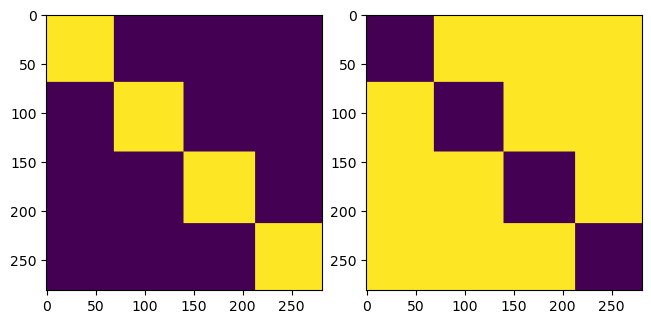

In [5]:
# check that it looks good
fig, axes = plt.subplots(1, 2, layout="constrained")
axes[0].imshow(within)
axes[1].imshow(across)

Now can compare average correlations within and across categories:

In [5]:
# we only need upper or lower triangle of matrix (without diagonal)
within_t = within[np.triu_indices(within.shape[0], 1)]
across_t = across[np.triu_indices(across.shape[0], 1)]
rdm_t = rdm[np.triu_indices(rdm.shape[0], 1)]

# indices to non-zero elements
i_w = np.where(within_t == True)
i_a = np.where(across_t == True)

rdm_tw = rdm_t[i_w]
rdm_ta = rdm_t[i_a]

# Mean correlations
print('Mean correlation within %f versus across %f.' % (np.mean(rdm_tw), np.mean(rdm_ta)))

Mean correlation within 0.077416 versus across 0.004949.


We see that the within-category correlations are larger than then the across-correlations - as expected.

We can corrlate the "model matrices" with the RDM. Let's compare a "model" for within-category correlations with a random model.

In [6]:
print('Model matrix correlation within %f vs all %f.' % (np.corrcoef(rdm_t, within_t)[0, 1], np.corrcoef(rdm_t, np.random.randn(rdm_t.shape[0]))[0, 1]))

Model matrix correlation within 0.172967 vs all -0.003799.


We could use the functions from the "Decoding" notebook to analyze latency windows and to compute pseudotrials.